In [2]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('../')

In [4]:
import torch
from diffusers.utils import load_image
from diffusers import DDPMScheduler
from diffusion_adapters import StableDiffusionPipelineAdapterEmbeddings
from prior_models import TransformerEmbeddingDiffusionModelv2
from sampling import  sample_user_images

In [5]:
model_id = "runwayml/stable-diffusion-v1-5"                                                                                                                                                                                                                
pipe = StableDiffusionPipelineAdapterEmbeddings.from_pretrained(model_id).to("cuda")
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")     
pipe.safety_checker = None # Prudes
device = "cuda"

C:\Users\Gabriel\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5\snapshots\451f4fe16113bff5a5d2269ed5ad43b0592e9a14


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [31]:
diffusion_prior_model = TransformerEmbeddingDiffusionModelv2(
    img_embed_dim=1024,
    num_users=94,    # So user embedding covers your entire user set
    n_heads=16,
    num_tokens=1,
    num_user_tokens=4,
    num_layers=8,
    dim_feedforward=2048,
    whether_use_user_embeddings=True
).to(device)

clip_sample = False
rescale_betas = False
noise_scheduler = DDPMScheduler(num_train_timesteps=6000, clip_sample=clip_sample, rescale_betas_zero_snr=rescale_betas)
savepath = f"../data/flickr/evaluation/diffusion_priors/models/weights/experiment_1/sd15_bs64_nslaplace_spu200_timesteps6000_clipsample{clip_sample}_rescalebetas{rescale_betas}.pth"
#savepath = f"../weights/sd15_experiments/sd15_nl8_heads16_dim_feedforward1024_lr0.0001_it1_ut4_adamw_reduce_on_plateau_bs128_nslinear_spu30_timesteps6000_objnoise-pred_useueTrue.pth"

diffusion_prior_model.load_state_dict(torch.load(savepath, weights_only=True))
diffusion_prior_model.eval()

c:\Users\Gabriel\anaconda3\envs\recgensys-env\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerEmbeddingDiffusionModelv2(
  (user_embedding): Embedding(95, 4096)
  (score_embedding): Embedding(3, 1024)
  (time_embedding): SinusoidalEmbedding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_fc): Linear(in_features=1024, out_features=1024, bias=True)
)

In [32]:

samples_per_user = 2
guidance_scale = 10.0
prompt=[""]
negative_prompt=[""]
#prompt=["high quality photo"]
#negative_prompt=["bad quality photo, letters"]
#prompt=["Realistic image, finely detailed, with balanced composition and harmonious elements. Dynamic yet subtle tones, versatile style adaptable to diverse themes and aesthetics, prioritizing clarity and authenticity."]
#negative_prompt=["deformed, ugly, wrong proportion, frame, watermark, low res, bad anatomy, worst quality, low quality"]

image_list = sample_user_images(
    diffusion_prior_model=diffusion_prior_model,
    diffusion_pipe=pipe,
    users=list(range(2)),
    images_per_user=samples_per_user,
    noise_scheduler=noise_scheduler,
    guidance_scale=guidance_scale,
    prompt=prompt,
    negative_prompt=negative_prompt,
    #1024 is SD15 emb size
    img_embedding_size=1024

)

[0, 1]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:54<00:54, 54.42s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 2/2 [01:48<00:00, 54.44s/it]


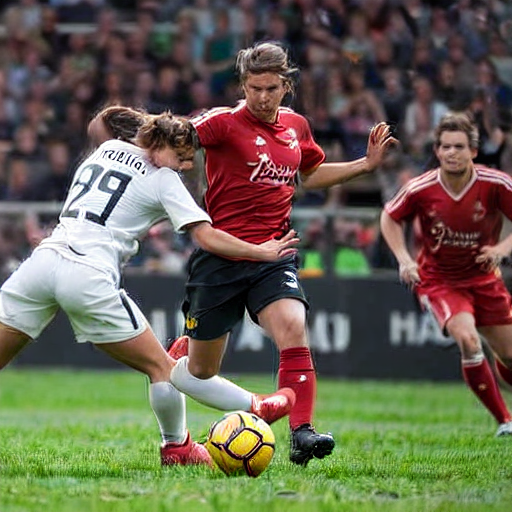

In [39]:
image_list[1]["images"][1]